# ResNet50

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np

data_dir = "/kaggle/input/microscopic-peripheral-blood-cell-images/PBC_dataset_normal_DIB"

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])

indices = list(range(len(full_dataset)))
train_idx, test_idx = train_test_split(indices, test_size=0.98, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.5, random_state=42)

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Test set: {len(test_dataset)} images")

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 8)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}') 
        print('-' * 10)

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct.double() / len(train_loader.dataset)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels.data)
                total += labels.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct.double() / len(val_loader.dataset)

        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        # Step scheduler
        scheduler.step()

        # Save the model if the validation accuracy is the best
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_resnet50.pth')

# Run the training function
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10)

# Evaluate the model on the test dataset
def test_model(model, test_loader):
    model.load_state_dict(torch.load('best_resnet50.pth'))
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

    test_acc = correct.double() / total
    print(f'Test Accuracy: {test_acc:.4f}')
    return test_acc

# Test the model
resnet_acc = test_model(model, test_loader).item()

Train set: 170 images
Validation set: 171 images
Test set: 16751 images


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 182MB/s]


Epoch 1/10
----------
Train Loss: 1.5692 Acc: 0.4176
Val Loss: 19.6683 Acc: 0.1754
Epoch 2/10
----------
Train Loss: 1.5415 Acc: 0.5000
Val Loss: 239.6043 Acc: 0.0409
Epoch 3/10
----------
Train Loss: 1.1245 Acc: 0.6294
Val Loss: 38.9805 Acc: 0.2047
Epoch 4/10
----------
Train Loss: 0.9229 Acc: 0.6765
Val Loss: 75.4779 Acc: 0.1287
Epoch 5/10
----------
Train Loss: 0.8463 Acc: 0.7235
Val Loss: 2.5146 Acc: 0.6199
Epoch 6/10
----------
Train Loss: 0.7350 Acc: 0.7647
Val Loss: 1.9453 Acc: 0.5965
Epoch 7/10
----------
Train Loss: 0.6388 Acc: 0.7941
Val Loss: 9.3284 Acc: 0.3567
Epoch 8/10
----------
Train Loss: 0.7139 Acc: 0.8059
Val Loss: 1.1572 Acc: 0.7076
Epoch 9/10
----------
Train Loss: 0.5567 Acc: 0.8235
Val Loss: 0.6317 Acc: 0.7602
Epoch 10/10
----------
Train Loss: 0.4580 Acc: 0.8294
Val Loss: 0.6596 Acc: 0.7778


/tmp/ipykernel_23/1048172915.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_resnet50.pth'))


Test Accuracy: 0.8031


/tmp/ipykernel_23/3677471368.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path))
100%|██████████| 524/524 [01:53<00:00,  

Test Loss: 0.6528, Test Acc: 0.8085

Classification Report:
              precision    recall  f1-score   support

   basophil        0.67      0.85      0.75      1192
  eosinophil       1.00      0.91      0.95      3057
erythroblast       0.72      0.70      0.71      1516
          ig       0.74      0.61      0.67      2827
  lymphocyte       0.76      0.64      0.70      1195
    monocyte       0.60      0.77      0.67      1388
  neutrophil       0.91      0.91      0.91      3261
    platelet       0.83      0.94      0.88      2315

    accuracy                           0.81     16751
   macro avg       0.78      0.79      0.78     16751
weighted avg       0.82      0.81      0.81     16751


Confusion Matrix:
[[1014    1   15   93    4    2   32   31]
 [  72 2767   45   55    3    6   56   53]
 [   6    3 1061   67  160   95   37   87]
 [ 300    0   58 1728   21  508  139   73]
 [  38    0  161   73  769   89    8   57]
 [  13    0   10  183   22 1070    2   88]
 [  55    1 

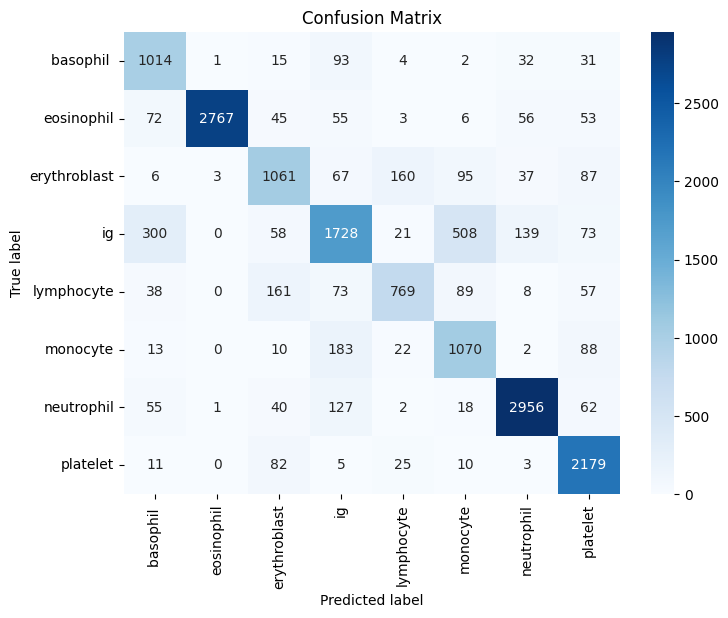

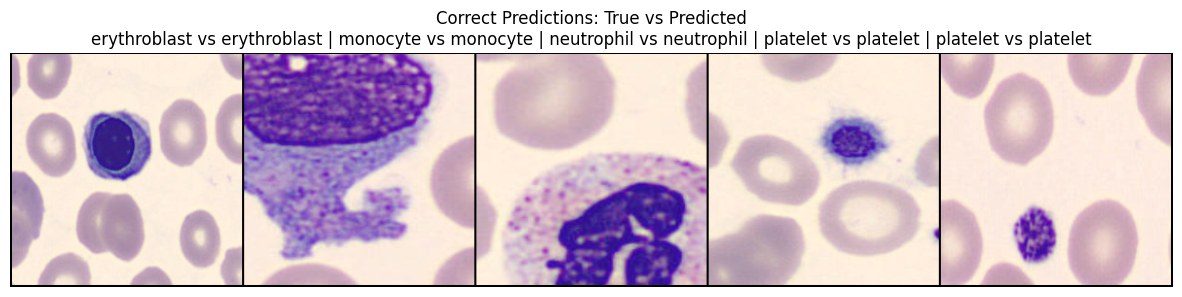

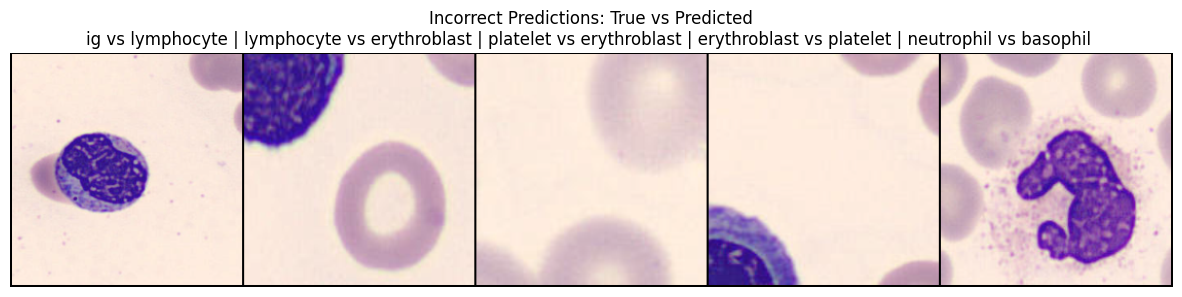

In [2]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import make_grid
import numpy as np
from tqdm import tqdm

def show_images_with_labels(images, true_labels, pred_labels, title, class_names, num_images=5):
    plt.figure(figsize=(15, 10))

    images = images[:num_images]
    true_labels = true_labels[:num_images]
    pred_labels = pred_labels[:num_images]

    img_grid = make_grid(images, nrow=num_images, normalize=True)
    npimg = img_grid.numpy()

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f"{title}: True vs Predicted\n" + " | ".join([f"{class_names[true]} vs {class_names[pred]}" for true, pred in zip(true_labels, pred_labels)]))
    plt.axis('off')
    plt.show()

def evaluate_model(model, test_loader, criterion, model_load_path='best_resnet50.pth', class_names=None):

    model.load_state_dict(torch.load(model_load_path))
    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    correct_images = []
    incorrect_images = []
    correct_true_labels = []
    correct_pred_labels = []
    incorrect_true_labels = []
    incorrect_pred_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            for i in range(len(predicted)):
                if predicted[i] == labels[i]:
                    correct_images.append(inputs[i].cpu())
                    correct_true_labels.append(labels[i].cpu().item())
                    correct_pred_labels.append(predicted[i].cpu().item())
                else:
                    incorrect_images.append(inputs[i].cpu())
                    incorrect_true_labels.append(labels[i].cpu().item())
                    incorrect_pred_labels.append(predicted[i].cpu().item())

    test_loss = test_loss / len(test_loader)
    test_acc = correct / total
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(conf_matrix)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

    if len(correct_images) > 0:
        show_images_with_labels(correct_images, correct_true_labels, correct_pred_labels, "Correct Predictions", class_names, num_images=5)

    if len(incorrect_images) > 0:
        show_images_with_labels(incorrect_images, incorrect_true_labels, incorrect_pred_labels, "Incorrect Predictions", class_names, num_images=5)

class_names = ['basophil ', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']

evaluate_model(model, test_loader, criterion, class_names=class_names)

# Mobile net

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np

# Path to your data directory with 8 subfolders for each class
data_dir = "/kaggle/input/microscopic-peripheral-blood-cell-images/PBC_dataset_normal_DIB"

# Define transformations for train, validation, and test
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the full dataset using ImageFolder
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])

# Get indices for the dataset
indices = list(range(len(full_dataset)))
train_idx, test_idx = train_test_split(indices, test_size=0.98, random_state=42)  # 98% for test

# Further split the remaining 2% into train and validation (1% each)
train_idx, val_idx = train_test_split(train_idx, test_size=0.5, random_state=42)

# Subset the datasets
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Test set: {len(test_dataset)} images")

# Number of classes (replace with the actual number of classes in your dataset)
num_classes = 8  # Modify based on your dataset

# Load the pretrained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

# Modify the final fully connected layer to match the number of classes
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training loop with dynamic number of epochs
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct.double() / len(train_loader.dataset)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels.data)
                total += labels.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct.double() / len(val_loader.dataset)

        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        # Step scheduler
        scheduler.step()

        # Save the model if validation accuracy improves
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_mobilenet_v2.pth')
            print(f"Best model saved with accuracy: {best_acc:.4f}")

# Example function call with dynamic number of epochs
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10)

# Evaluate the model on the test dataset
def test_model(model, test_loader):
    model.load_state_dict(torch.load('best_mobilenet_v2.pth'))
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

    test_acc = correct.double() / total
    print(f'Test Accuracy: {test_acc:.4f}')
    return test_acc

# Test the model
mobile_acc = test_model(model, test_loader).item()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Train set: 170 images
Validation set: 171 images
Test set: 16751 images


100%|██████████| 13.6M/13.6M [00:00<00:00, 71.5MB/s]


Epoch 1/10
----------
Train Loss: 1.5962 Acc: 0.4294
Val Loss: 1.2635 Acc: 0.5965
Best model saved with accuracy: 0.5965
Epoch 2/10
----------
Train Loss: 0.6015 Acc: 0.8059
Val Loss: 2.1710 Acc: 0.4795
Epoch 3/10
----------
Train Loss: 0.4327 Acc: 0.8353
Val Loss: 0.9931 Acc: 0.7251
Best model saved with accuracy: 0.7251
Epoch 4/10
----------
Train Loss: 0.4787 Acc: 0.8412
Val Loss: 1.4749 Acc: 0.7485
Best model saved with accuracy: 0.7485
Epoch 5/10
----------
Train Loss: 0.5112 Acc: 0.8118
Val Loss: 2.5314 Acc: 0.4971
Epoch 6/10
----------
Train Loss: 0.4540 Acc: 0.8353
Val Loss: 1.4253 Acc: 0.6199
Epoch 7/10
----------
Train Loss: 0.4491 Acc: 0.8647
Val Loss: 0.9465 Acc: 0.7953
Best model saved with accuracy: 0.7953
Epoch 8/10
----------
Train Loss: 0.2502 Acc: 0.9235
Val Loss: 0.5815 Acc: 0.8246
Best model saved with accuracy: 0.8246
Epoch 9/10
----------
Train Loss: 0.2782 Acc: 0.9000
Val Loss: 0.4475 Acc: 0.8596
Best model saved with accuracy: 0.8596
Epoch 10/10
----------
Train

/tmp/ipykernel_23/3260959261.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_mobilenet_v2.pth'))


Test Accuracy: 0.8778


/tmp/ipykernel_23/1608157499.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path))
100%|██████████| 524/524 [01:27<00:00,  

Test Loss: 0.3614, Test Acc: 0.8826

Classification Report:
              precision    recall  f1-score   support

   basophil        0.94      0.89      0.92      1192
  eosinophil       0.99      0.98      0.98      3057
erythroblast       0.85      0.87      0.86      1516
          ig       0.84      0.69      0.76      2827
  lymphocyte       0.92      0.78      0.84      1195
    monocyte       0.68      0.83      0.75      1388
  neutrophil       0.91      0.95      0.93      3261
    platelet       0.89      0.97      0.93      2315

    accuracy                           0.88     16751
   macro avg       0.87      0.87      0.87     16751
weighted avg       0.89      0.88      0.88     16751


Confusion Matrix:
[[1065    7   10   73    3    5   19   10]
 [   0 3000   11    6    4    2    9   25]
 [   1    4 1322   32   50   31   17   59]
 [  50   19   93 1953   10  429  240   33]
 [   4    0   52   66  933   54   10   76]
 [   2    5   26  133   10 1158    8   46]
 [   2    7 

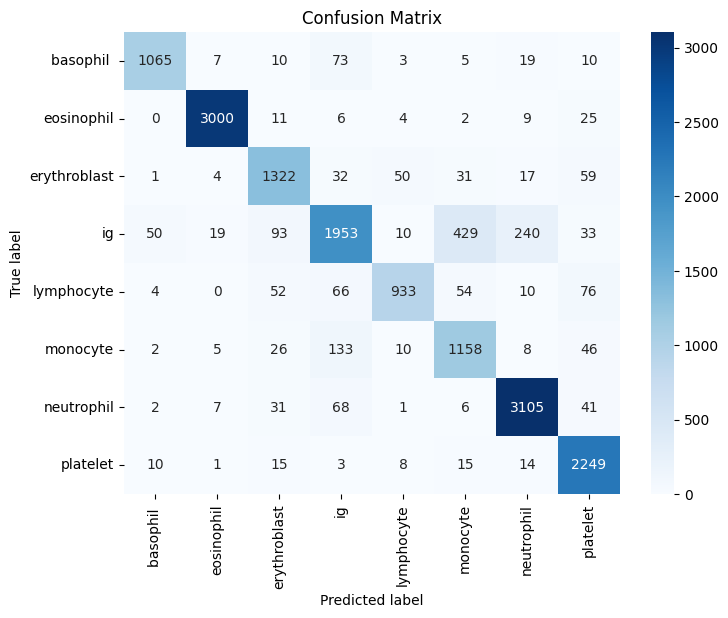

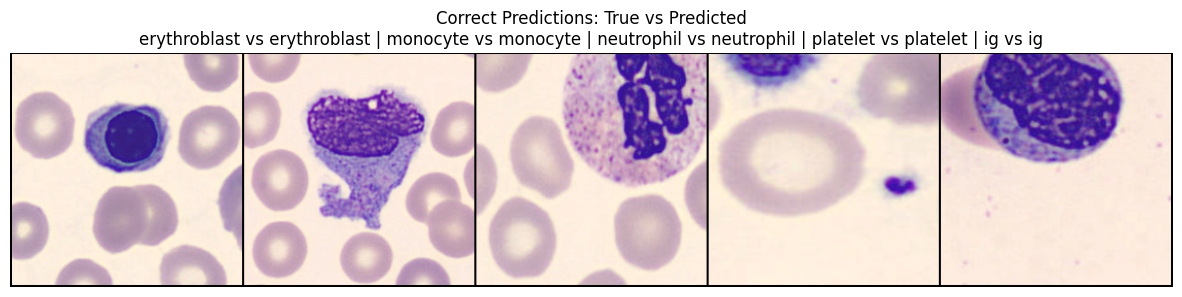

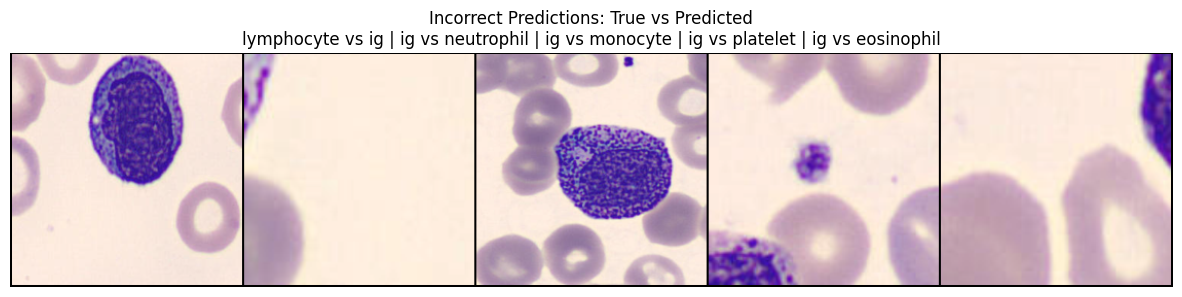

In [4]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import make_grid
import numpy as np
from tqdm import tqdm

# Function to display images with true vs predicted labels
def show_images_with_labels(images, true_labels, pred_labels, title, class_names, num_images=5):
    plt.figure(figsize=(15, 10))
    # Select only the first `num_images`
    images = images[:num_images]
    true_labels = true_labels[:num_images]
    pred_labels = pred_labels[:num_images]

    # Create a grid of images
    img_grid = make_grid(images, nrow=num_images, normalize=True)
    npimg = img_grid.numpy()

    # Display the images with the true and predicted labels
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f"{title}: True vs Predicted\n" + " | ".join([f"{class_names[true]} vs {class_names[pred]}" for true, pred in zip(true_labels, pred_labels)]))
    plt.axis('off')
    plt.show()

# Evaluation function with confusion matrix and detailed metrics
def evaluate_model(model, test_loader, criterion, model_load_path='best_mobilenet_v2.pth', class_names=None):
    # Load the best model
    model.load_state_dict(torch.load(model_load_path))
    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    correct_images = []
    incorrect_images = []
    correct_true_labels = []
    correct_pred_labels = []
    incorrect_true_labels = []
    incorrect_pred_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect labels and predictions for metrics
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # Store some correct and incorrect predictions
            for i in range(len(predicted)):
                if predicted[i] == labels[i]:
                    correct_images.append(inputs[i].cpu())
                    correct_true_labels.append(labels[i].cpu().item())
                    correct_pred_labels.append(predicted[i].cpu().item())
                else:
                    incorrect_images.append(inputs[i].cpu())
                    incorrect_true_labels.append(labels[i].cpu().item())
                    incorrect_pred_labels.append(predicted[i].cpu().item())

    test_loss = test_loss / len(test_loader)
    test_acc = correct / total
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(conf_matrix)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

    if len(correct_images) > 0:
        show_images_with_labels(correct_images, correct_true_labels, correct_pred_labels, "Correct Predictions", class_names, num_images=5)

    if len(incorrect_images) > 0:
        show_images_with_labels(incorrect_images, incorrect_true_labels, incorrect_pred_labels, "Incorrect Predictions", class_names, num_images=5)

class_names = ['basophil ', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']

evaluate_model(model, test_loader, criterion, class_names=class_names)

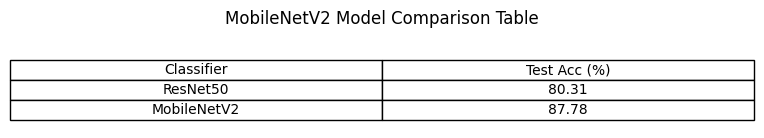

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
data = {
    'Classifier': ['ResNet50', 'MobileNetV2'],
    'Test Acc (%)': [round(resnet_acc*100,2), round(mobile_acc*100,2)]
}
df = pd.DataFrame(data)
fig, ax = plt.subplots(figsize=(8, 1))
ax.axis('tight')
ax.axis('off')
tbl = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2) 
plt.title(f'MobileNetV2 Model Comparison Table', pad=20)
plt.show()